<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/SVD%EB%A5%BC_MLP_NCF%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

In [11]:
#json불러오기
df = pd.read_json('user_rating_1000.json')


In [12]:


# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation='relu')(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation='relu')(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation='relu')(mlp_layer)
mlp_layer = Dense(1)(mlp_layer)  # 평점 예측

# 모델 생성 및 컴파일
model = Model(inputs=[user_input, item_input], outputs=mlp_layer)
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 15)                15000     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 15)                24945     ['input_2[0][0]']             
                                                                                              

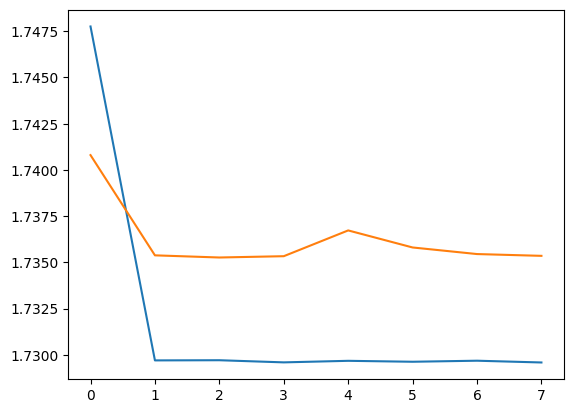

In [20]:
# train loss와 val loss 같이 시각화
# plt.plot(history.history['root_mean_squared_error'])
# plt.plot(history.history['val_root_mean_squared_error'])

# # train mse와 val mse 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

모델이 특정 수준의 성능에 도달한 후 추가적인 학습으로 크게 개선되지 않았음.

In [21]:
# 모델 저장
model.save('model0426_2311.h5')

In [15]:
# user_id==11의 평점이 0인데이터, 그린까 아직 평점을 매기지 않은 장소 구하기
unrated_places = pivot_table.loc[11].loc[pivot_table.loc[11] == 0].index
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model('model0425_2200.h5')

df2 = df.copy()

# 모델 예측
predictions = model.predict([df2['user_id'], df2['place_id']])

# 예측 평점 출력
print(predictions)

# df2에 'predict_rating' 컬럼추가하기
df2['predict_rating'] = predictions

51969/51969 [==============================] - 100s 2ms/step


KeyboardInterrupt: 

In [ ]:
# user아이디가 11인 사람의 실제 평점과 예측평점
df2[df2['user_id'] == 11].sort_values(by='rating', ascending=False)

In [ ]:
# user아이디가 11인 사람의 예측평점구하기
df2[df2['user_id'] == 11][df2['rating']== 0].sort_values(by='predict_rating', ascending=False).head(10)

In [ ]:
df.info()